In [56]:
# Cargamos unas librerias
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
# Carga el archivo CSV en 5 primeras lineas
df = pd.read_csv(r"C:\Users\Mgh59\OneDrive\Escritorio\Clave Python SQL\Portafolio\productos\sales_trends.csv")
df.head()

,date,sales,promotions_active,marketing_spend
0,2022-01-01,1001.32,1,857.10
1,2022-01-02,1015.42,1,1168.49
2,2022-01-03,985.06,0,857.93
3,2022-01-04,997.00,0,1044.37
4,2022-01-05,946.04,0,1145.83


In [58]:
# Vemos la informacion del documento
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               730 non-null    object 
 1   sales              730 non-null    float64
 2   promotions_active  730 non-null    int64  
 3   marketing_spend    730 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 22.9+ KB


### Limpieza

In [59]:
# Contamos nulos
df.isnull().sum()

date                 0
sales                0
promotions_active    0
marketing_spend      0
dtype: int64

In [60]:
# Revisamos duplicados 
df.duplicated().sum() 

0

In [61]:
# Eliminar filas sin fecha o sin sales
df.dropna(subset=['date', 'sales'], inplace=True)

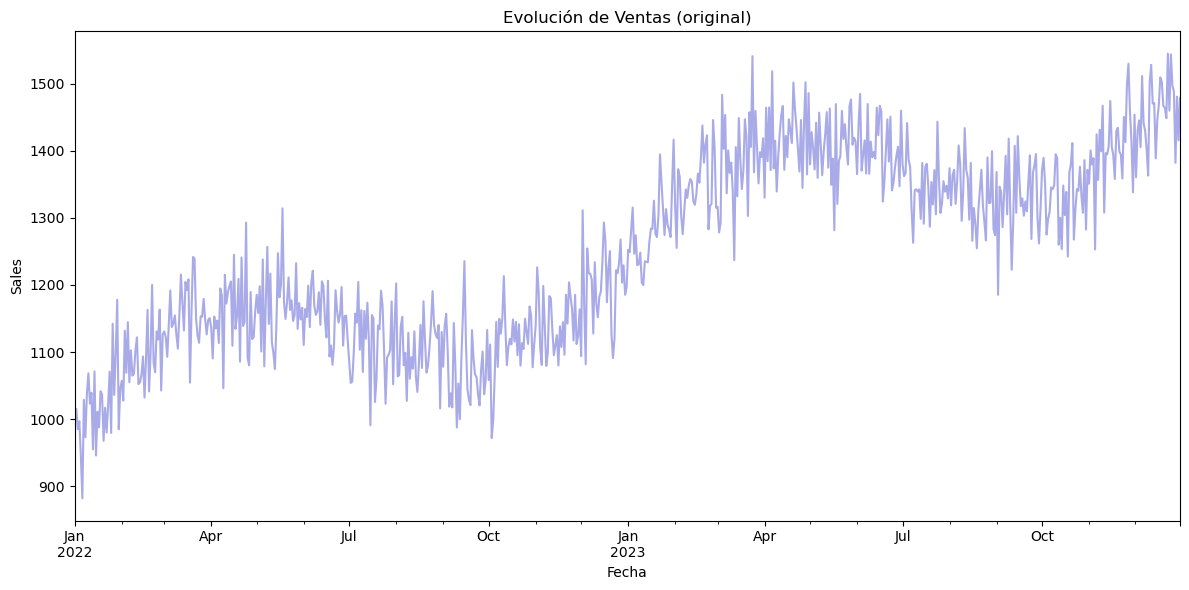

In [62]:
# Convertir fechas a formato datetime completo 
df['date'] = pd.to_datetime(df['date'])

# Establecer como índice
df.set_index('date', inplace=True) 
df = df.sort_index()

# Visualizar la serie 
#df['sales'].plot(figsize=(12,6), title='Evolución de Ventas', color='#082032');

plt.figure(figsize=(12,6))
df['sales'].plot(title='Evolución de Ventas (original)', color='#a9aae8')
plt.ylabel('Sales')
plt.xlabel('Fecha')
plt.tight_layout()
plt.show()

### Media Movil

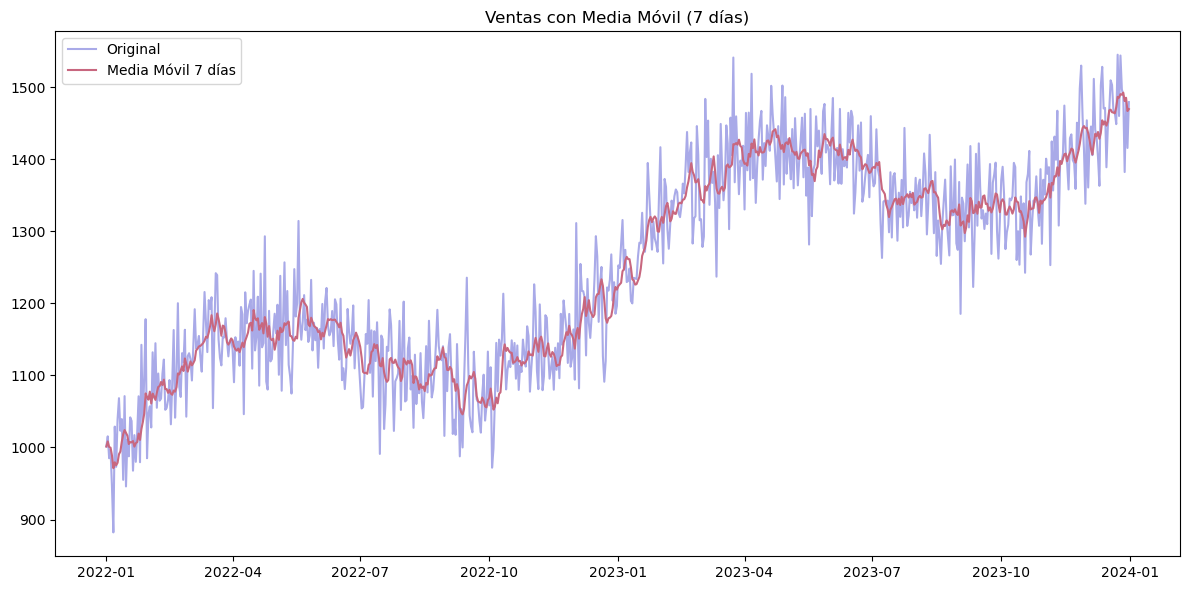

In [63]:
# Media móvil de 7 días
df['rolling_7d'] = df['sales'].rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(12,6))
plt.plot(df.index, df['sales'], label='Original', color='#a9aae8')
plt.plot(df.index, df['rolling_7d'], label='Media Móvil 7 días', color='#c8677f')
plt.title('Ventas con Media Móvil (7 días)')
plt.legend()
plt.tight_layout()
plt.show()
      

### Conteo de Ventas por Día

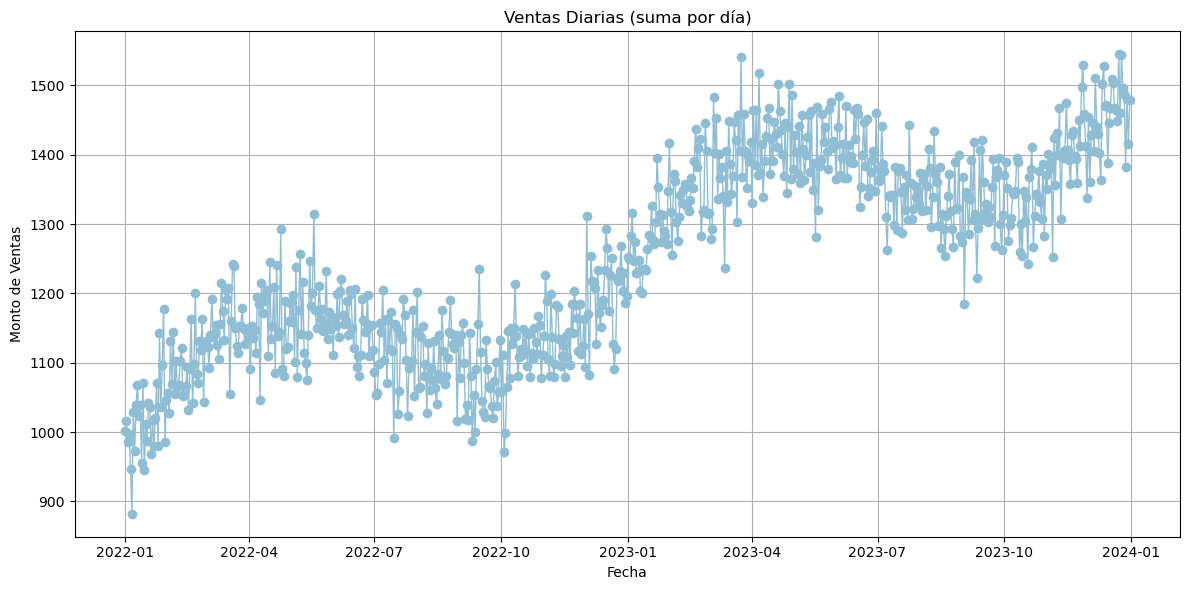

In [64]:
# Si 'date' es el índice:
ventas_diarias = df['sales'].resample('D').sum()

plt.figure(figsize=(12,6))
plt.plot(ventas_diarias.index, ventas_diarias.values, marker='o', linewidth=1, color='#8fbdd3')
plt.title('Ventas Diarias (suma por día)')
plt.xlabel('Fecha')
plt.ylabel('Monto de Ventas')
plt.grid(True)
plt.tight_layout()
plt.show()

### ARIMA

In [65]:
from statsmodels.tsa.stattools import adfuller

serie_adf = ventas_diarias.dropna()  # adfuller no admite NaN

# Usamos la columna de ventas diarias
serie_ventas = df['sales']

# Prueba de Dickey-Fuller aumentada
resultado = adfuller(serie_adf)

print(f'ADF Statistic: {resultado[0]}')
print(f'p-value: {resultado[1]}')

if resultado[1] < 0.05:
    print("La serie es estacionaria (rechazamos H0)")
else:
    print("La serie NO es estacionaria (no se rechaza H0)")

ADF Statistic: -1.116833653593017
p-value: 0.7083123666121562
La serie NO es estacionaria (no se rechaza H0)


<Figure size 1000x500 with 0 Axes>

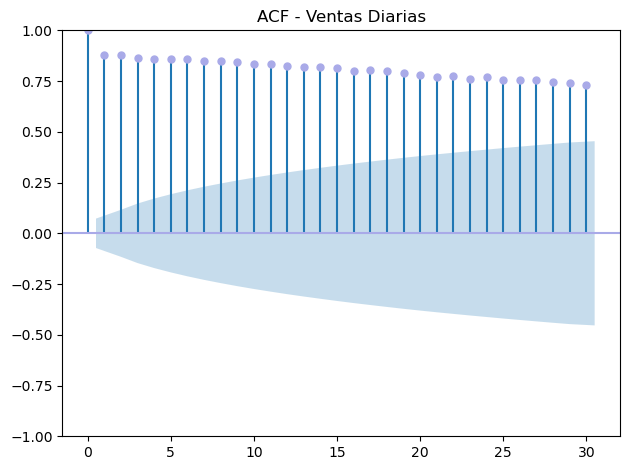

<Figure size 1000x500 with 0 Axes>

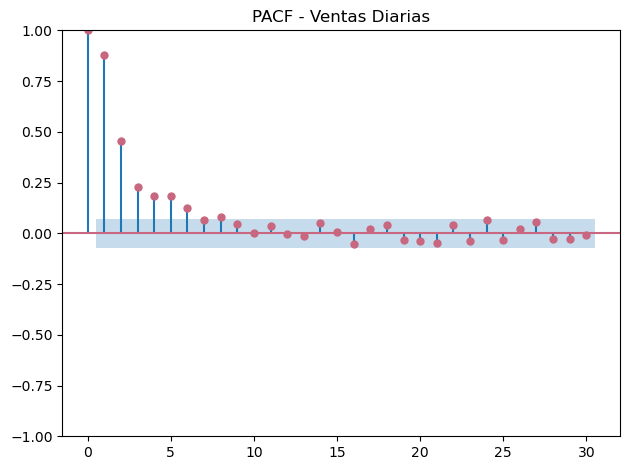

In [66]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10,5))
plot_acf(serie_adf, lags=30, color='#a9aae8')
plt.title("ACF - Ventas Diarias")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
# Si plot_pacf falla con un método, elimina 'method' o prueba otro
plot_pacf(serie_adf, lags=30, method='ywm', color='#c8677f')
plt.title("PACF - Ventas Diarias")
plt.tight_layout()
plt.show()

In [67]:
# Búsqueda automática del mejor modelo(p,d,q) y un resumen del ajuste
from pmdarima import auto_arima

auto = auto_arima(serie_adf, seasonal=False, trace=True,  error_action='ignore', suppress_warnings=True, stepwise=True)
print(auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7820.592, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8223.295, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8014.705, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7815.292, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8221.363, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7817.291, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7817.291, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7819.047, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7819.644, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.133 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  730
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3904.646
Date:                Tue, 07 Oct 2025   AIC      

In [68]:
from statsmodels.tsa.arima.model import ARIMA

# Creamos el modelo ARIMA mas completo
modelo = ARIMA(serie_ventas, order=(0, 1, 1))
modelo_fit = modelo.fit()
print(modelo_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  730
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3907.822
Date:                Tue, 07 Oct 2025   AIC                           7819.644
Time:                        07:21:53   BIC                           7828.828
Sample:                    01-01-2022   HQIC                          7823.187
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8592      0.020    -43.867      0.000      -0.898      -0.821
sigma2      2647.4138    139.275     19.008      0.000    2374.439    2920.388
Ljung-Box (L1) (Q):                   0.08   Jarque-

c:\Users\Mgh59\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Mgh59\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Mgh59\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [69]:
# Pronóstico ARIMA: próximos 7 días
steps = 7
pred_arima = modelo_fit.get_forecast(steps=steps)
pred_mean = pred_arima.predicted_mean
pred_ci = pred_arima.conf_int()

In [70]:
# Crear índice de fechas futuras
last_date = serie_adf.index[-1]
future_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps, freq='D')
pred_series = pd.Series(pred_mean.values, index=future_index)

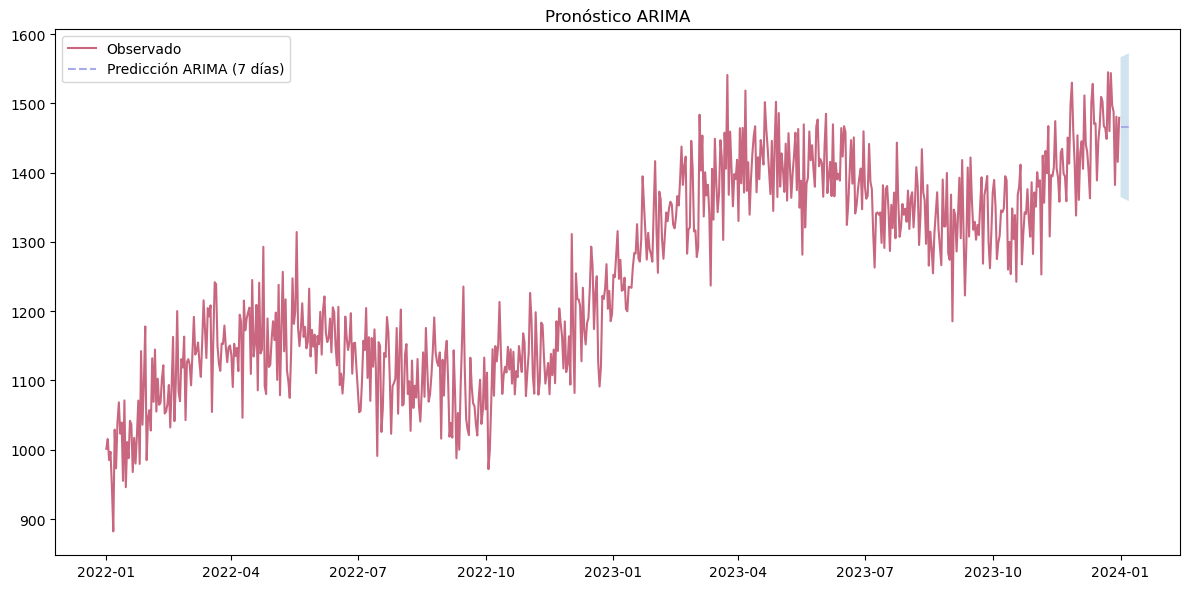


Predicción ARIMA (7 días):
2024-01-01    1465.556996
2024-01-02    1465.556996
2024-01-03    1465.556996
2024-01-04    1465.556996
2024-01-05    1465.556996
2024-01-06    1465.556996
2024-01-07    1465.556996
Freq: D, dtype: float64


In [71]:
# Graficar pronóstico ARIMA
plt.figure(figsize=(12,6))
plt.plot(serie_adf.index, serie_adf.values, label='Observado',color='#c8677f')
plt.plot(pred_series.index, pred_series.values, label='Predicción ARIMA (7 días)', linestyle='--', color='#a9aae8')
plt.fill_between(future_index,
                 pred_ci.iloc[:, 0].values,
                 pred_ci.iloc[:, 1].values,
                 alpha=0.2)
plt.legend()
plt.title('Pronóstico ARIMA')
plt.tight_layout()
plt.show()

print("\nPredicción ARIMA (7 días):")
print(pred_series)

### Prophet

In [72]:
from prophet import Prophet

# Preparar DataFrame para Prophet: columnas 'ds' y 'y'
df_prophet = serie_adf.reset_index().rename(columns={'date': 'ds', 'sales': 'y'})


In [73]:
# Quitar tz si existiera
if pd.api.types.is_datetime64tz_dtype(df_prophet['ds']):
    df_prophet['ds'] = df_prophet['ds'].dt.tz_convert(None).dt.tz_localize(None)


C:\Users\Mgh59\AppData\Local\Temp\ipykernel_26608\3200110203.py:2: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(df_prophet['ds']):


In [74]:
# Ajustar Prophet
m = Prophet()
m.fit(df_prophet)

07:22:08 - cmdstanpy - INFO - Chain [1] start processing
07:22:08 - cmdstanpy - INFO - Chain [1] done processing


In [75]:
# Crear futuro y predecir
futuro = m.make_future_dataframe(periods=7, freq='D')
forecast = m.predict(futuro)

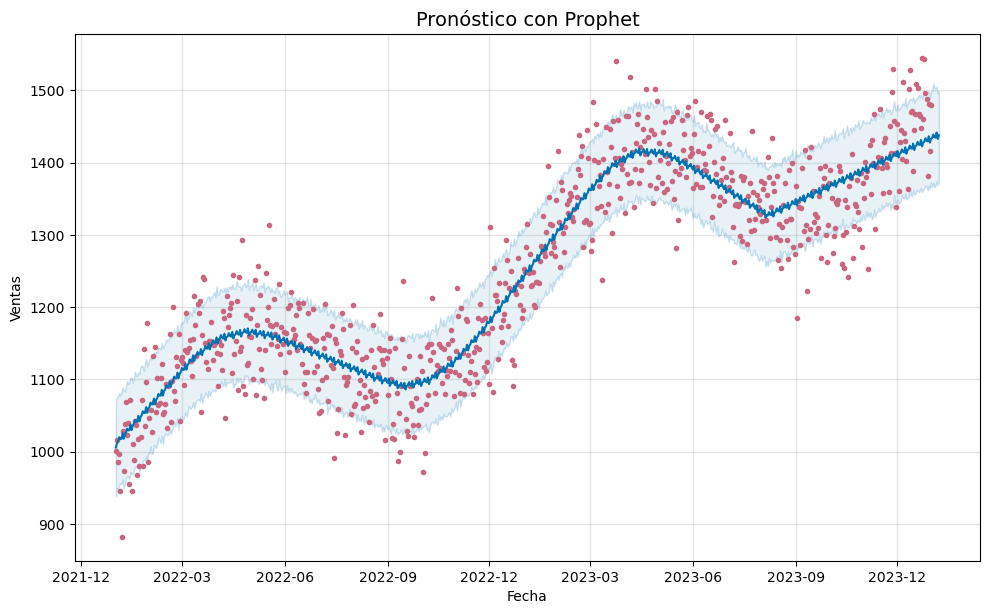

: 

In [ ]:
# Graficar resultado Prophet
fig1 = m.plot(forecast)  # genera el gráfico por defecto
ax = fig1.gca()          # obtiene el eje actual
# Cambiar el color de la línea principal (predicción)
line = ax.get_lines()[0]
line.set_color('#c8677f')

# Opcional: cambiar color de las bandas de confianza (relleno)
for collection in ax.collections:
    collection.set_alpha(0.2)  # transparencia
    collection.set_facecolor('#8fbdd3')  # color de las bandas

# Títulos y etiquetas
plt.title('Pronóstico con Prophet', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.show()

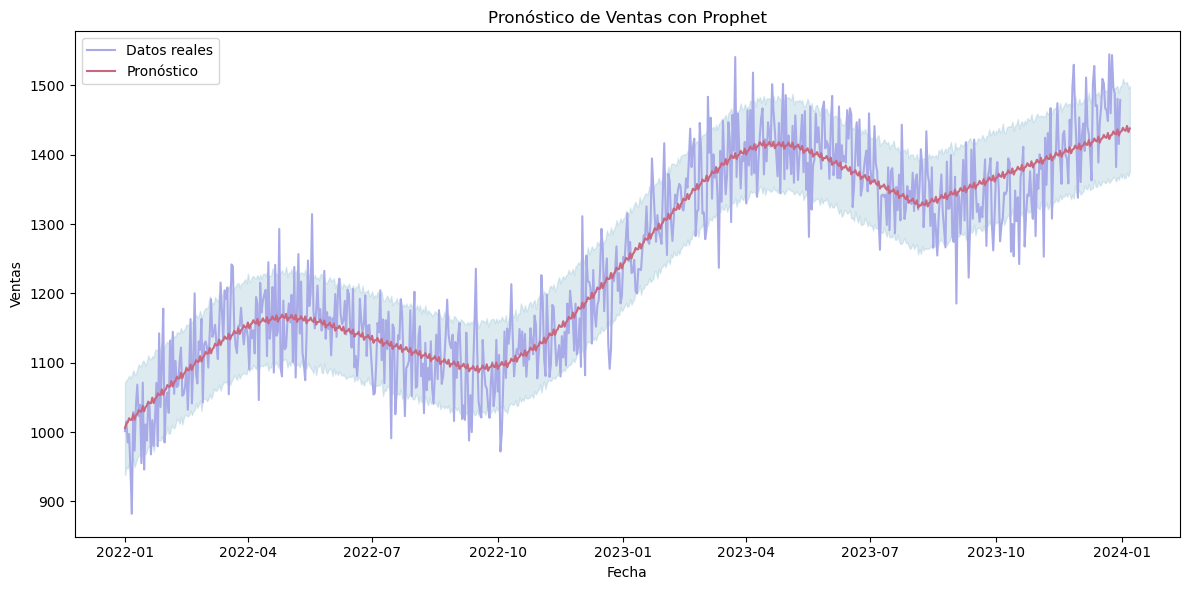

In [85]:
# Datos reales + predicción Prophet
plt.figure(figsize=(12,6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Datos reales', color='#a9aae8')
plt.plot(forecast['ds'], forecast['yhat'], label='Pronóstico', color='#c8677f')
plt.fill_between(forecast['ds'],
                 forecast['yhat_lower'],
                 forecast['yhat_upper'],
                 color='#8fbdd3', alpha=0.3)
plt.title('Pronóstico de Ventas con Prophet')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.tight_layout()
plt.show()

In [77]:
top5_dias = ventas_diarias.sort_values(ascending=False).head(5)
print("\nTop 5 días con más ventas (suma por día):")
print(top5_dias)



Top 5 días con más ventas (suma por día):
date
2023-12-23    1544.81
2023-12-25    1543.68
2023-03-24    1540.89
2023-11-27    1529.70
2023-12-12    1527.98
Name: sales, dtype: float64


In [78]:
dia_max = ventas_diarias.idxmax()
print(f"\nDía con más ventas (fecha): {dia_max.date()}  - Monto: {ventas_diarias.loc[dia_max]}")


Día con más ventas (fecha): 2023-12-23  - Monto: 1544.81
